In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

In [2]:
print("\nQuantum+Chips Summer School : July 29 - August 9 (2024)")
print("University of Minnesota")
print("Spintronics Lab (Instructor: Duarte Sousa)\n")

write_time_evolution = True
magnetization_trajectory = True

Ms = 1.27e6
gamma = 2.2e5
alpha = 0.01
Keff = 1e4
tFree = 1e-9
H_ext = 0e4
J_SOT = -0.5e10
J_STT = 2e10

theta_z_FL = 0.0
theta_z_DL = 0.298
theta_y_FL = 0.0
theta_y_DL = 1

t_initial = 0
t_final = 80e2
dt = 30e-2
initial_orientation = 'z'
anisotropy_axis = 'z'


Quantum+Chips Summer School : July 29 - August 9 (2024)
University of Minnesota
Spintronics Lab (Instructor: Duarte Sousa)



In [3]:
def Heff(theta_t, phi_t, Mx, My, Mz, H_ext, Keff, anisotropy_axis, Ms):
    mu0 = 12.56637e-7
    Hk_eff = 2 * Keff / (Ms * mu0)
    Nx = Ny = Nz = 0.0
    Hd_eff_x = -Ms * Nx
    Hd_eff_y = -Ms * Ny
    Hd_eff_z = -Ms * Nz

    if anisotropy_axis == 'x':
        H_eff = np.array([(Hk_eff * Mx + Hd_eff_x * Mx), Hd_eff_y * My, (H_ext + Hd_eff_z * Mz)])
    elif anisotropy_axis == 'y':
        H_eff = np.array([Hd_eff_x * Mx, (Hk_eff * My + Hd_eff_y * My), (H_ext + Hd_eff_z * Mz)])
    else:  # 'z'
        H_eff = np.array([Hd_eff_x * Mx, Hd_eff_y * My, (Hk_eff * Mz + H_ext + Hd_eff_z * Mz)])

    hx_eff, hy_eff, hz_eff = H_eff / Ms
    h_r_t = hx_eff * np.sin(theta_t) * np.cos(phi_t) + hy_eff * np.sin(theta_t) * np.sin(phi_t) + hz_eff * np.cos(theta_t)
    h_theta_t = hx_eff * np.cos(theta_t) * np.cos(phi_t) + hy_eff * np.cos(theta_t) * np.sin(phi_t) - hz_eff * np.sin(theta_t)
    h_phi_t = -hx_eff * np.sin(phi_t) + hy_eff * np.cos(phi_t)
    return h_r_t, h_theta_t, h_phi_t, Hk_eff

In [4]:
def Heff_DL(J_SOT, J_STT, sigma_zx_z, sigma_zx_y, tFree, Ms):
    mu0 = 12.56637e-7
    hbar = 1.054571800e-34
    e = 1.602e-19
    sigma_xx = 2000
    hall_angle_zx_z = sigma_zx_z / sigma_xx
    hall_angle_zx_y = sigma_zx_y / sigma_xx
    C = hbar / (2 * e)
    D = 1 / (mu0 * Ms**2)
    h_z_DL_t = hall_angle_zx_z * C * D * J_STT / tFree
    h_y_DL_t = hall_angle_zx_y * C * D * J_SOT / tFree
    return h_z_DL_t, h_y_DL_t

In [5]:
def Heff_FL(J_SOT, J_STT, sigma_zx_z, sigma_zx_y, tFree, Ms):
    return Heff_DL(J_SOT, J_STT, sigma_zx_z, sigma_zx_y, tFree, Ms)



In [6]:
NT = int(round((t_final - t_initial) / dt))
time_range = np.linspace(t_initial, t_final, NT)
Dt = 1e9 * dt / (Ms * gamma)

sigma_zx_z_FL = theta_z_FL * 2000
sigma_zx_z_DL = theta_z_DL * 2000
sigma_zx_y_FL = theta_y_FL * 2000
sigma_zx_y_DL = theta_y_DL * 2000

if initial_orientation == 'x':
    phi_t = np.deg2rad(0.05)
    theta_t = np.deg2rad(90 + 0.05)
elif initial_orientation == 'y':
    phi_t = np.deg2rad(90 + 0.05)
    theta_t = np.deg2rad(90 + 0.05)
else:
    phi_t = np.deg2rad(0.05)
    theta_t = np.deg2rad(0.05)

mx = [np.cos(phi_t) * np.sin(theta_t)]
my = [np.sin(phi_t) * np.sin(theta_t)]
mz = [np.cos(theta_t)]

Mx, My, Mz = mx[0], my[0], mz[0]
phi_list, theta_list, real_time = [], [], []

In [7]:
for t in range(1, NT):
    time = time_range[t]
    _, h_eff_theta_t, h_eff_phi_t, Hk_eff = Heff(theta_t, phi_t, Mx, My, Mz, H_ext, Keff, anisotropy_axis, Ms)
    h_z_DL_t, h_y_DL_t = Heff_DL(J_SOT, J_STT, sigma_zx_z_DL, sigma_zx_y_DL, tFree, Ms)
    h_z_FL_t, h_y_FL_t = Heff_FL(J_SOT, J_STT, sigma_zx_z_FL, sigma_zx_y_FL, tFree, Ms)

    B1 = h_eff_theta_t + h_z_FL_t * np.sin(theta_t) - h_y_FL_t * np.cos(theta_t) * np.sin(phi_t) + h_y_DL_t * np.cos(phi_t)
    B2 = h_eff_phi_t + h_z_DL_t * np.sin(theta_t) - h_y_FL_t * np.cos(phi_t) - h_y_DL_t * np.cos(theta_t) * np.sin(phi_t)

    theta_tdt = theta_t + dt * (B2 + alpha * B1) / (1 + alpha**2)
    phi_tdt = phi_t + dt * (-B1 + alpha * B2) / ((1 + alpha**2) * np.sin(theta_t))

    mx.append(np.cos(phi_tdt) * np.sin(theta_tdt))
    my.append(np.sin(phi_tdt) * np.sin(theta_tdt))
    mz.append(np.cos(theta_tdt))
    phi_list.append(phi_tdt)
    theta_list.append(theta_tdt)
    real_time.append(1e9 * time / (Ms * gamma))
    Mx, My, Mz = mx[-1], my[-1], mz[-1]
    phi_t, theta_t = phi_tdt, theta_tdt

In [8]:
mx = np.array(mx[:len(real_time)])
my = np.array(my[:len(real_time)])
mz = np.array(mz[:len(real_time)])
real_time = np.array(real_time)

plt.figure(figsize=(8, 3))
plt.plot(real_time, mx, label='m_x', linewidth=1)
plt.plot(real_time, my, label='m_y', linewidth=1)
plt.plot(real_time, mz, label='m_z', linewidth=1)
plt.xlabel("time (ns)")
plt.ylabel("Magnetization Components")
plt.ylim([-1.1, 1.1])
plt.legend()
plt.tight_layout()
plt.savefig("mag_time_evolution.jpg", dpi=300)
plt.close()

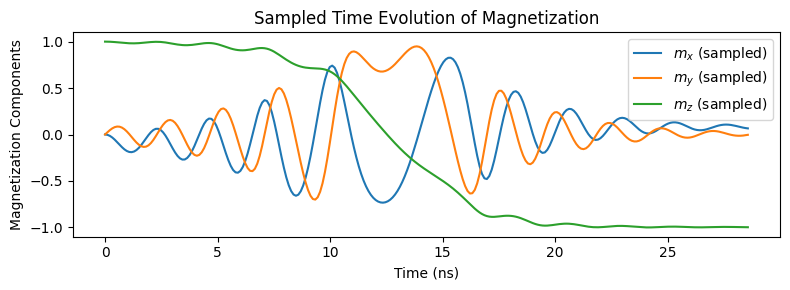

In [9]:
if write_time_evolution:
    plt.figure(figsize=(8, 3))
    plt.plot(real_time[::100], mx[::100], label=r'$m_x$ (sampled)')
    plt.plot(real_time[::100], my[::100], label=r'$m_y$ (sampled)')
    plt.plot(real_time[::100], mz[::100], label=r'$m_z$ (sampled)')
    plt.xlabel("Time (ns)")
    plt.ylabel("Magnetization Components")
    plt.title("Sampled Time Evolution of Magnetization")
    plt.legend()
    plt.tight_layout()
    plt.show()